# Project 4: Camera Projection Matrix Estimation


## Brief

* Due:
    * Tuesday, 11/10/2020 11:59pm
    
* Project materials including writeup 
* Hand-in: [gradescope](https://www.gradescope.com/)
* Required files:
    * `\<your_gt_username\>.zip`
    * `\<your_gt_username\>_proj3.pdf`

## Outline

The project is composed of 4 parts.

1. **Estimate projection Matrix**: you need to understand the composition of projection matrix, how 3D points are projected to corresponding 2D points and how to refine your projection matrix.

2. **Visualize your own camera pose and structure**: you will need to use previously implemented functions to calculate and visualize camera pose and structure of your own image

3. **Convert 3D points from world coordinates to camera coordinates**

4. **Direct Linear Transform (DLT)**: an alternate method to compute the projection matrix.


## Setup

Note that we will be using a new environment for this project! If you run into import module errors, try “pip install -e .” again, and if that still doesn’t work, you may have to create a fresh environment. You can refer to the README.md to install the environment.

## Note

When you try to `Cell->Run All` or `Kernel->Restart & Run All`, it's known that matplotlib may show blank plots. If you run into this problem, please try to restart the kernel and run the cells one by one. Refer [here](https://stackoverflow.com/questions/47507830/matplotlib-plots-not-showing-on-jupyter-notebook-when-i-run-all) for more details.

In [1689]:
%matplotlib inline
# %matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from proj4_code.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notations

- The superscript on the left always denotes the coordinate frame in which a quantity is being represented.
- ${}^w\mathbf{X}$ for 3D points in world coordinate frame.
- ${}^w\mathbf{x}$ for 2D points in world coordinate frame.
- ${}^wR_c$: for rotation of the camera in the world coordinate frame
- ${}^wt_c$: for translation of the camera in the world coordinate frame




# Part 1 Projection Matrix Estimation

**Learning Objective**: (1) Understanding the the camera projection matrix and (2) estimating it using fiducial objects for camera projection matrix estimation and pose estimation.

**Introduction**

In this first part you will perform pose estimation in an image taken by an uncalibrated camera. As we saw in class, pose estimation is incredibly useful; it is used in VR, AR, controller tracking, autonomous driving, and even satellite docking. Recall that for a pinhole camera model, the camera matrix P∈R3×4 is a projective mapping from world (3D) to pixel (2D) coordinates defined up to a scale.

\begin{align}
{}^w \mathbf{x} \cong f({}^w \mathbf{X};\mathbf{P}) = \mathbf{P} \:  {}^w \mathbf{X} 
\end{align}

where the congruency arises because scale is lost due to camera projection. Using an arbitary scale factor $s$, we can write:

$$
    {}^w \mathbf{x} = \begin{bmatrix}
        u \\
        v \\
        1
    \end{bmatrix} \cong \begin{bmatrix}
        s \cdot u \\
        s \cdot v \\
        s
    \end{bmatrix} = \mathbf{P} \:  {}^w \mathbf{X} =  \begin{bmatrix}
        p_{11} & p_{12} & p_{13} & p_{14} \\
        p_{21} & p_{22} & p_{23} & p_{24} \\
        p_{31} & p_{32} & p_{33} & p_{34} \\
    \end{bmatrix} \begin{bmatrix}
        {}^w x \\
        {}^w y \\
        {}^w z \\
        1
    \end{bmatrix}
$$


The camera matrix can also be decomposed into intrinsic parameters K and extrinsic parameters ${}^w \mathbf{R}_c, \: {}^w \mathbf{t}_c$.

$\mathbf{P} = \mathbf{K} \: {}^w \mathbf{R}_c^\top [\mathbf{I}\;|\; -{}^w \mathbf{t}_c].$

\begin{align}
\mathbf
{P}=
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

Let’s look more carefully into what each of the individual parts of the decomposed matrix mean. The homogenous vector coordinates $\mathbf{X}_w$ indicate the position of a point in 3D space in the world coordinate system. The matrix $[\mathbf{I}\;\mid\; -{}^w\mathbf{t}_c]$ represents a translation and the matrix ${}^w \mathbf{R}^T_c$ represents a rotation. When combined they convert points from the **world to the camera coordinate system**. An intuitive way to understand this is to think about how aligning the axes of the world coordinate system to the ones of the camera coordinate system can be done with a rotation and a translation.

<img src="https://dellaert.github.io/19F-4476/images/proj3/coordiante_systems.png" width="500"/>
<center>The distinction between camera coordinate and world coordinate systems is a rotation and a translation.</center>

**Note:** it is very important you understand the coordinate systems in the diagram above. We have the world coordinate system defined at the corner of the cuboid. X, Y, and Z axes are denoted by Red, Green, and Blue color respectively. We have the camera coordinate system defined on the camera. Notice the direction of the three axes. In CV community, we define the camera coordinate system as follows: X is horizontal and to the left, Y goes down vertically, and Z is projected out towards the scene.

In this part of the project you will learn how to estimate the projection matrix using objective function minimization, how you can decompose the camera matrix, and what knowing these lets you do.


## Part 1.1 Projection from camera coordinate (3D) to frame coordinate (2D)

In this initial part, in `projection_matrix.py` you will implement camera projection in the `projection(P, points_3d)` from homogenous world coordinates ${}^w \mathbf{X}^i = [{}^w x^i, {}^w y_i, {}^w z_i, 1]$ to non-homogenous pixel coordinates $u^i, v^i$, where $i$ denotes the input index.

It will be helpful to recall the equations to convert to pixel coordinates

$$
u^i = \frac{p_{11} {}^w \mathbf{X}^i +p_{12} {}^w \mathbf{Y}^i + p_{13} {}^w \mathbf{Z}^i + p_{14}}{p_{31} {}^w \mathbf{X}^i +p_{32} {}^w \mathbf{Y}^i + p_{33} {}^w \mathbf{Z}^i + p_{34}} \quad v^i = \frac{p_{21} {}^w \mathbf{X}^i+p_{22} {}^w \mathbf{Y}^i + p_{23} {}^w \mathbf{Z}^i + p_{24}}{p_{31} {}^w \mathbf{X}^i + p_{32} {}^w \mathbf{Y}^i + p_{33}{}^w \mathbf{Z}^i + p_{34}}
$$

**TODO:** implement `projection()` in `projection_matrix.py`

In [1690]:
import projection_matrix
# np.set_printoptions(suppress=True) # Suppresses printing in scientific notation

from unit_tests.part1_unit_test import (
    verify, 
    test_projection, 
    test_objective_func,
    test_decompose_camera_matrix,
    test_calculate_camera_center,
    test_estimate_camera_matrix)

In [1691]:
print('Test for camera projection:', verify(test_projection))

Test for camera projection: "Correct"


## Part 1.2 Objective(cost) function to refine the projection matrix**

A camera projection matrix maps points from 3D into 2D. How can we use this to estimate its parameters? Assume that we have N known 2D-3D correspondences for a set of points, that is, for points with index $i= 1\dots N$ we have both access to the respective 3D coordinates ${}^w \mathbf{X}^{i}$ and 2D coordinates ${}^w \mathbf{x}^{i}$. Let $\hat{\mathbf{P}}$ be an estimation for the camera projection matrix. We can determine how accurate the estimation is by measuring the reprojection error:

$$
\sum_{i=1}^N ( \color{purple}{\hat{\mathbf{P}} \: {}^w \mathbf{X}^i \: - \: {}^w \mathbf{x}^i })^2
$$

between the 3D points projected into 2D $\hat{\mathbf{P}} \: {}^w \mathbf{X}^i$ and the known 2D points ${}^w \mathbf{x}^i$, both in **non-homogeneous** coordinates. Therefore we can estimate the projection matrix itself by minimizing the reprojection error with respect to the projection matrix

\begin{align}
\underset{\hat{\mathbf{P}}}{\arg\min}\sum_{i=1}^N (\hat{\mathbf{P}}\: {}^w \mathbf{X}^i \: - \: {}^w \mathbf{x}^i )^2 .
\end{align}

In this part, in `projection_matrix.py` you will implement the objective function `objective_function(x, **kwargs)` that will be passed to `scipy.optimize.least_squares` for minimization with the Levenberg-Marquardt algorithm. The input to this function is a [vectorized](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) camera matrix, the output is the term that gets squared in the objective function and should also be vectorized. Scipy takes care of the squaring + summation part.

**TODO:** implement `objective_function()` in `projection_matrix.py`

In [1692]:
print('Test for objective_function:', verify(test_objective_func))

Test for objective_function: "Correct"


## Part 1.3 Estimating the projection matrix given initial estimation, 3D-2D point correspondence and previous objective function**

Optimizing the reprojection loss using Levenberg-Marquardt requires a good initial estimate for $\mathbf{P}$. This can be done by having good initial estimates for $\mathbf{K}$ and ${}^w\mathbf{R}_c$ and ${}^w \mathbf{t}_c $ which you can multiply to then generate your estimated $\mathbf{P}$ not K. In this part, to make sure that you have the least squares optimization working properly we will provide you with an initial estimate. In the function you will have to implement in this part, `estimate_projection_matrix()`, you will have to pass the initial guess to `scipy.optimize.least_squares` and get the appropriate output.

Note: because $P$ has only 11 degrees of freedom, we fix $ \mathbf{P}_{34=1} $.

Initially you will run the optimization to estimate $\mathbf{P}$ using an initial guess that we provide.

Optimizing the reprojection loss using Levenberg-Marquardt requires a **good initial estimate for $\mathbf{P}$**. This can be done by having good initial estimates for $\mathbf{K}$ and ${}_w\mathbf{R}_c^T$ and $\mathbf{t}$ which you can multiply to then generate your estimated $\mathbf{K}$.

In [1693]:
initial_guess_K = np.array([[ 500,   0, 535],
                            [   0, 500, 390],
                            [   0,   0,  -1]])

initial_guess_wRc_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_wtc = np.array([[   1,    0, 0, 300],
                              [   0,    1, 0, 300],
                              [   0,    0, 1,  30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_wRc_T, initial_guess_I_wtc))

In [1694]:
# set the paths and load the data
pts2d_path = '../data/pts2d-pic_b.txt'
pts3d_path = '../data/pts3d.txt'
img_path   = '../data/pic_b.jpg'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(img_path)

**TODO:** implement `estimate_camera_matrix()` in `projection_matrix.py`

Time since optimization start 0.25475192070007324
The projection matrix is
 [[-2.04554508e+00  1.18126375e+00  4.05588148e-01  2.44822741e+02]
 [-4.55828586e-01 -3.04147973e-01  2.14988413e+00  1.66188164e+02]
 [-2.24222867e-03 -1.09957031e-03  5.71552114e-04  1.00000000e+00]]
The total residual is 14.711475


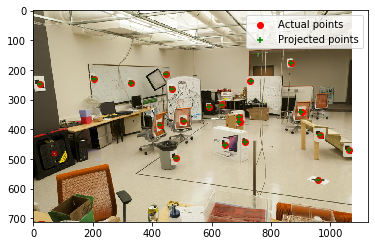

In [1695]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/pic_b.jpg')


In [1696]:
print('Test for estimate_camera_matrix:', verify(test_estimate_camera_matrix))

Time since optimization start 0.2875998020172119
Test for estimate_camera_matrix: "Correct"


## Part 1.4 Decompose projection matrix by RQ decomposition

Recall that $ \mathbf{P} =\mathbf{K}\ {}^w \mathbf{R}^T_c[\mathbf{I}| -{}^w\mathbf{t}_c] $. Rewriting this gives us:

\begin{align}
\mathbf{P} &= \mathbf{K}\ {}^w \mathbf{R}^T_c [ \mathbf{I}| -{}^w\mathbf{t}_c ] \\
    &= \mathbf{K}\ {}^c \mathbf{R}_w [ \mathbf{I} | -{}^w\mathbf{t}_c ] \\
    &= [ \mathbf{K}\ {}^c \mathbf{R}_w | - \mathbf{K} {}^c \mathbf{R}_w {}^w\mathbf{t}_c ]  \\
    &= [ \mathbf{K}\ {}^c \mathbf{R}_w | \mathbf{K}\ {}^c\mathbf{t}_w ] \\
    &= [\mathbf{M}| \mathbf{K}\ {}^c\mathbf{t}_w ]
\end{align}

Where $\mathbf{M} = \mathbf{K}\ {}^c\mathbf{R}_w $ is the first 3 columns of $\mathbf{P}$. An operation known as RQ decomposition which will decompose $ \mathbf{M} $ into an upper triangular matrix $R$ and an orthonormal matrix $Q$ such that $ R Q = \mathbf{M} $, where the upper triangular matrix will correspond to $ \mathbf{K} $ and the orthonormal matrix to $ {}^c\mathbf{R}_w $. In this part in `projection_matrix.py` you will implement `decompose_camera_matrix(P)` that takes as input the camera matrix $\mathbf{P}$ and outputs the intrinsic $\mathbf{K}$ and rotation matrix ${}^c\mathbf{R}_w$, 

**TODO:** implement `decompose_camera_matrix()` in `projection_matrix.py`

In [1697]:
print('Test for decomposing projection matrix:', verify(test_decompose_camera_matrix))
K, cRw = projection_matrix.decompose_camera_matrix(P)

Test for decomposing projection matrix: "Correct"


## Part 1.5 Calculate Camera Center by previous optimized P, intrinsic matrix K and rotation matrix $ {}^c\mathbf{R}_w $

In this part in `projection_matrix.py` you will implement `calculate_camera_center(P, K, cRw)` that takes as input the 
projection $\mathbf{P}$, intrinsic $\mathbf{K}$ and rotation ${}^c \mathbf{R}_w$ matrix and outputs the camera position in world coordinates.

**TODO:** implement `calculate_camera_center()` in `projection_matrix.py`

In [1698]:
print('Test for calculating camera center:', verify(test_calculate_camera_center))
center = projection_matrix.calculate_camera_center(P, K, cRw)

Test for calculating camera center: "Correct"


We can now visualize the camera center and the camera coordinate system as well as the  the world coordinate system.

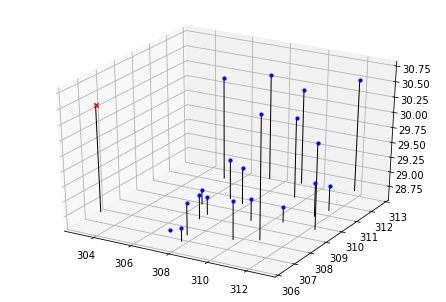

In [1699]:
plot3dview(points_3d, center)

### Questions
*put these answers in your report*

1. At least how many 3D-2D point correspondences do you need to estimate the projection matrix? Why?

## Part 2: Taking Your Own Images and Estimating the Projection Matrix + Camera Pose

In part 1 you were given a set of known points in world coordinates. In this part of the assignment you will learn how to use a fiducial---an object of known size that can be used as a reference. Any object for which you have measured the size given some unit (in this project you should use centimeters).

![projection_figure.png](https://dellaert.github.io/19F-4476/images/proj3/projection_figure.png)

<center>Example of how one cuboid of known dimensions can be used as a fiducial to create multiple world coordinate systems<center>

 <br>

The figure above illustrates how a cuboid of known dimension can be used to create a world coordinate system and a set of points with known 3D location. Choose an object that you will use as a fiducial (we recommend using a thick textbook) and measure it. Using a camera capture two images of the object (you will estimate the camera parameters for both images) keeping in mind the considerations discussed in class for part 2 and fundamental matrix estimation if you want to reuse these images. When taking the images, try to estimate the pose of the camera lens of your phone in the world coordinate system.

Now that you have the dimension of your object (3D points), you can use the Jupyter notebook to find the image coordinates of the 3D points create your own 2D-3D correspondences for each image. For each of your 2 images, make initial estimates for $\mathbf{P}$ and if your estimate is good, using your code from the previous part you should be able to estimate both the the projection matrix and the camera pose. Use the code available in the Jupyter notebook to visualize your findings.

### Part 2.1 Take two images of your fiducial object and mark 2D-3D correspondences

Choose a rigid object as your fiducial. Please consider using a **box-like fiducial object**, for example a book, because you will need to draw bounding box over your fiducial object, and it's easier to use a box-like fiducial object.

**TODO**: Fill out the `points_3d` variable with the 3D point locations of the points you'll use for correspondences. You can fix the world origin and the coordinate system at one of the corner of your fiducial object, and use a ruler to mark the coordinates of other points (e.g. corners of the book). Use a ruler to record the points in world coordinate frame. Also, do not forget to use the origin as one of the point.

**Note**: you need to mark the atleast the bare minimum points required for computing the projection matrix.

In [1852]:
points_3d = np.array([[0    , 0,  0],
                      [23.5 , 0,  0],
                      [0    , 21, 0],
                      [0    , 0,  2],
                      [23.5 , 0 , 2],
                      [23.5 , 21, 2],
                      [0    , 21, 2]])

**TODO:** take two images from different viewpoints by yourself and save it under the *../data/* path. Ensure that the viewpoints are different but all the 3D points you have in previous cell are visible in both the images.

In [1853]:
# image1_path = '../data/book_img1.jpg'
# image2_path = '../data/book_img2.jpg'
image1_path = '../data/liquid_love_1.jpg'
image2_path = '../data/liquid_love_2.jpg'

img1 = load_image(image1_path)
img2 = load_image(image2_path)

**TODO**: Now for each image, find the 2D pixel locations of your 3D points. Hovering over the interactive images below, and it will give you the `x,y` coordinates of your cursor on the image. The coordinates will be displayed in the bottom right corner. You can use the lower left side controls to zoom into the image for more precise measurements. 

<IPython.core.display.Javascript object>


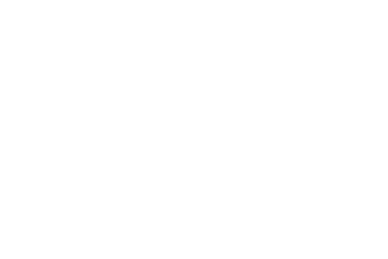

<IPython.core.display.Javascript object>


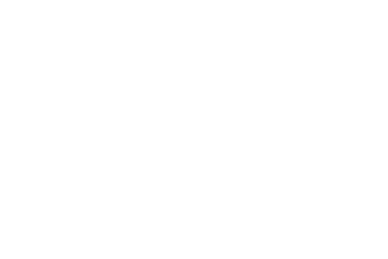

In [1854]:
# it's known to have problem (showing blank plot) when switching from `matplotlib inline` 
# to `matplotlib notebook`, and calling `matplotlib notebook` twice can resolve that
# in some cases. 
# refer: https://stackoverflow.com/questions/41125690/matplotlib-notebook-showing-a-blank-histogram?noredirect=1&lq=1
# %matplotlib notebook
%matplotlib notebook

# plotting image 1
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img1)

In [1855]:
# points2d_img1 = np.array([[700,  3210],
#                           [230,  1710],
#                           [2565, 2410],
#                           [636,  2878],
#                           [176,  1465],
#                           [1555, 1085],
#                           [2640, 2135]])
points2d_img1 = np.array([[920,  3220],
                          [410,  1680],
                          [2620, 2550],
                          [900,  3050],
                          [400,  1500],
                          [1590, 1210],
                          [2660, 2370]])


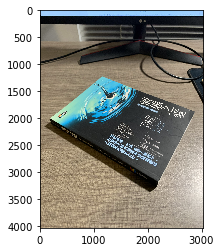

In [1710]:
# plotting image 2
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img2)

In [1856]:
# points2d_img2 = np.array([[2356, 3210],
#                           [154, 2169],
#                           [2794, 1884],
#                           [2487, 2902],
#                           [90, 1873],
#                           [1140, 1073 ],
#                           [2859, 1577]])
points2d_img2 = np.array([[2170, 3300],
                          [155, 2200],
                          [2820, 1900],
                          [2820, 2100],
                          [2170, 3100],
                          [155, 2000],
                          [1140, 1200 ]])


Lets visualize your marked points and ensure that you are fairly close to the correct location.

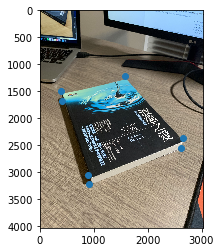

In [1857]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img1)
ax.scatter(points2d_img1[:, 0], points2d_img1[:, 1])
plt.show()

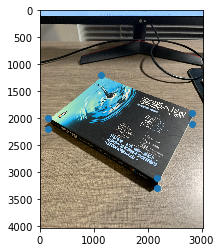

In [1858]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img2)
ax.scatter(points2d_img2[:, 0], points2d_img2[:, 1])
plt.show()

Our objective function will need to read the measurements you just saved from disk. 

In [1859]:
np.savetxt('../data/pts3d_fiducial.npy', points_3d)
np.savetxt('../data/pts2d_image1.npy', points2d_img1)
np.savetxt('../data/pts2d_image2.npy', points2d_img2)

## Part 2.2 Making your own $\mathbf{K}$,  ${}_w\mathbf{R}_c^T$ and $[\mathbf{I}|- {}^w \mathbf{t}_c ]$ estimates and visualize your camera pose.

**TODO:** Fill the initial estimations to compose your P and visualize the camera poses.

**Note:** 
- You have defined your world coordinate frame by yourself. So recall the position of your camera when you took the image, and try to find out the camera rotation and translation in world coordinate frame. You do not have to be exact, but rather be in the correct ballpark. And use the same units you used when measuring 3D points (e.g. cm/inches/etc).
- For intrinsics, you can initialize it using the size of the image as $\begin{bmatrix} W & 0 & W/2 \\
    0 & H & H/2 \\
    0 & 0 & 1 \end{bmatrix}$


In [1869]:
initial_guess_K = np.array([[ 1000,   0, 2000],
                            [   0, 1000, 1500],
                            [   0,   0,  1]])

initial_guess_wRc_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_t = np.array([[   1,    0, 0, -30],
                              [   0,    1, 0, 20],
                              [   0,    0, 1, 30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_wRc_T, initial_guess_I_t))

In [1870]:
# set the paths and load the data
pts2d_path = '../data/pts2d_image1.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([2016., 1512.])

Visualize your estimate for the camera pose relative to the world coordinate system. RGB colors correspond with XYZ (first, second and third coordinate). Be mindful of whether you should be passing `R` or `R.T` in for your rotation matrix.

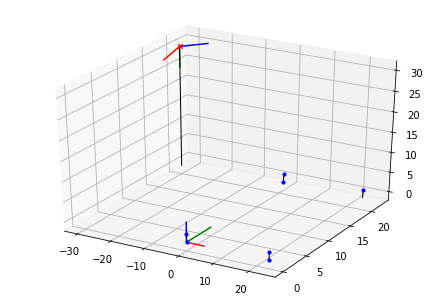

In [1871]:
%matplotlib inline
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_wRc_T.T)

Make sure that your initial estimate makes sense. Check the location of the camera, its axes, the world coordinate system, and 3D points.

View the optimization results given your initial guess. If your initial guess is poor the optimizition **will not** work. You will need to make initial estimates for both the images you took.

Time since optimization start 0.04192066192626953
The projection matrix is
 [[-1.09389430e+01  9.99388252e+01 -2.92562509e+01  9.19998416e+02]
 [-2.45582815e+01 -1.33204464e+01 -1.57244064e+02  3.22589007e+03]
 [ 2.50066409e-02  7.36196063e-03 -2.17943005e-02  1.00000000e+00]]
The total residual is 52.039234


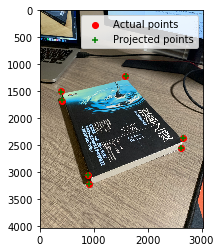

In [1872]:
P1 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
print('The projection matrix is\n', P1)

[projected_2d_pts, residual] = evaluate_points(P1, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

Give the initial estimation of P for pictures you take and visualize your estimate for the camera pose relative to the world coordinate system.

In [1864]:
# set the pats and load the data
pts2d_path = '../data/pts2d_image2.npy'
pts3d_path = '../data/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([2016., 1512.])

In [1865]:
initial_guess_K = np.array([[ 1000,   0, 2000],
                            [   0, 1000, 1500],
                            [   0,   0,  1]])

initial_guess_wRc_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_t = np.array([[   1,    0, 0, -30],
                              [   0,    1, 0, 30],
                              [   0,    0, 1, 10]])

#-30 30 10 1778

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_wRc_T, initial_guess_I_t))

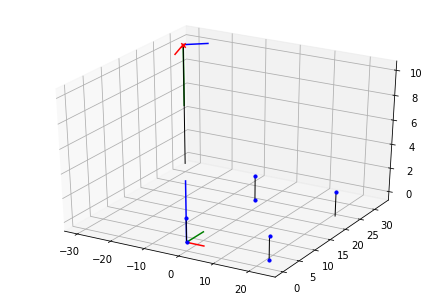

In [1866]:
plot3dview_with_coordinates(points_3d, initial_guess_I_t[:,3], initial_guess_wRc_T.T) #change this plot to show the world coordinate system better

Time since optimization start 0.1720600128173828
The projection matrix is
 [[ 2.09190602e+01 -6.93929898e+03  7.24322366e+04  2.16846820e+03]
 [ 1.28544519e+03 -5.75790848e+03  5.94930481e+04  3.30372220e+03]
 [ 5.86671304e-01 -2.46513967e+00  2.59560888e+01  1.00000000e+00]]
The total residual is 1644.588506


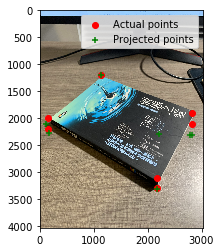

In [1867]:
P2 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
#M = sc.calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', P2)

[projected_2d_pts, residual] = evaluate_points(P2, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image2_path)
#visualize_points(points_2d, projected_2d_pts)

Use the two intrinsic matrix K1, K2 and  Visualizing both camera poses in the world coordinate system.

[-18.08406412  -4.24725428  23.69933278]
[-0.75007723  9.81066394  0.91017972]


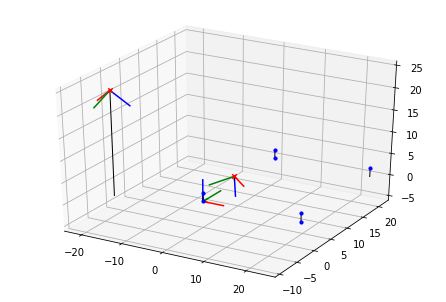

In [1868]:
K1, R1 = projection_matrix.decompose_camera_matrix(P1)
center_1 = projection_matrix.calculate_camera_center(P1, K1, R1);
print(center_1)

K2, R2 = projection_matrix.decompose_camera_matrix(P2)
center_2 = projection_matrix.calculate_camera_center(P2, K2, R2);
print(center_2)

plot3dview_2_cameras(points_3d, center_1, center_2, R1.T, R2.T)

### Questions
*put these answers in your report*

* What would happen to the projected points if you increased/decreased the x coordinate, or the other coordinates of the camera center t? Write down a description of your expectations in the appropriate part of your writeup submission.

* Perform this shift for each of the camera coordinates and then recompose the projection matrix and visualize the result in the Jupyter notebook. Was the visualized result what you expected?

## Part 2.3 Visualize bounding boxes in the images you take

In this part you will visualize a bounding boxes around the box-like fiducial objecct in each of the two images you take. Although only 6 or 7 out of 8 vertices of your box-like fiducial object are visible in your image, you can easily compute the coordinates in the world coordinate system for rest vertices.

With these coordinates in the world coordinate system, we'll need to project them to the camera coordinate system, and then draw bounding boxes using these 8 projected vertices.

**TODO**: implement `visualize_bounding_box()` function in `projection_matrix.py`, and plot the bounding box around your box-like fiducial object in your own image. **Please include the images with bounding box in your report.**

In [1820]:
# find the 3D coordinates of your box-like fiducial object. 
# The following are coordinates for the image we provide you,
# please replace them with your own.
# Keep in mind that you'll need 8 coordinates of all 8 vertices
# of your box-like fiducial object.
points_3d = np.array([[0    , 0,  0], 
                      [23.5 , 0,  0], 
                      [23.5 , 21, 0], 
                      [0    , 21, 0], 
                      [0    , 0,  2], 
                      [23.5 , 0 , 2], 
                      [23.5 , 21, 2], 
                      [0    , 21, 2]])

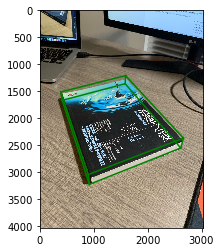

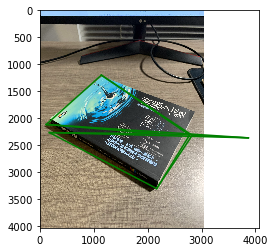

In [1821]:
# visualize your bounding box.
projection_matrix.visualize_bounding_box(P1, points_3d, img1)
projection_matrix.visualize_bounding_box(P2, points_3d, img2)

# Part 3: Convert 3D points from world coordinates to camera coordinates

## Part 3.1 Transformation matrix

So far, all the 3D point coordinates we used are in the world coordinate system, which is often used because we are able to speak about the positions of objects independently of where the camera is. But sometimes, we would also like to use the camera coordinate system, so we can express the position of any points from the viewpoint of the camera, which will make projection from 3D to 2D easier. In this part, you'll need to transform the points you measured previously from world coordinates to camera coordinates.

To do so, we will need to define a transformation from point $({}^w X, {}^w Y, {}^w Z)$ in world coordinates to its location $({}^c X, {}^c Y, {}^c Z)$ in camera coordinates. Since we are using homogeneous coordinates, we will use a $4\times4$ translation and rotation matrix.

Suppose the position of the camera’s center in world coordinates is ${}^w \mathbf{t}_c$. If we wish to transform any other point ${}^w \mathbf{X}$ into the camera’s coordinate system, we first subtract off ${}^w \mathbf{t}_c$, so the origin now becomes the camera center, and then we perform a rotation ${}^c \mathbf{R}_w$, so the X, Y, and Z axes align with the axes of the camera:
$${}^c \mathbf{X} = {}^w\mathbf{R}_c^T \ ({}^w \mathbf{X} - {}^w \mathbf{t}_c) = {}^w \mathbf{R}_c^T\ {}^w \mathbf{X} - {}^w\mathbf{R}_c^T \ {}^w\mathbf{t}_c$$

In homogeneous coordinates, this becomes
$$\begin{bmatrix}X_c\\Y_c\\Z_c\\1\end{bmatrix} = \begin{bmatrix}\mathbf{{}_wR_c^T} & -\mathbf{{}_wR_c^T}\ {}_w\mathbf{t}_c\\0^\top  & 1\\\end{bmatrix}\begin{bmatrix}X_w\\Y_w\\Z_w\\1\end{bmatrix}$$

where $ 0^\top $ is a 1x3 vector.

**TODO**: implement `transformation_matrix(wRc_T, wtc)` in `camera_coordinates.py`.

In [1724]:
from unit_tests.part3_unit_test import (
    verify, 
    test_transformation_matrix, 
    test_convert_3d_points_to_camera_coordinate,
    test_projection_from_camera_coordinates)

In [1725]:
print('Test for transformation matrix:', verify(test_transformation_matrix))

Test for transformation matrix: "Correct"


## Part 3.2 Transform from world coordinates to camera coordinates

Now, Let's do the actual transformation from world coordinate system to camera coordinate system using the transformation matrix you just compute.

**TODO**: implement `convert_3d_points_to_camera_coordinate(points_3d_c, M)` in `camera_coordinates.py`

In [1726]:
print('Test for transformation to camera coordinates:', verify(test_convert_3d_points_to_camera_coordinate))

Test for transformation to camera coordinates: "Correct"


## Part 3.3 Projection from 3D to 2D in camera coordinate system

After we have converted the 3D points from world coordinate system to camera coordinate system, we can now do the 3D to 2D projection in camera coordinate system, which should be much easier than doing this projection in the world coordinate system. Recall from our early lecture of Geometric Image formation, projecting a 3D points $({}^cX, {}^c Y, {}^c Z)$ in camera coordinates to 2D $(u, v, w)$ can be done easily by:

$$\begin{bmatrix} u\\v\\w\end{bmatrix} = \mathbf{K}[\mathbf{I}|\mathbf{0}] \begin{bmatrix}{}^c X\\{}^c Y\\{}^c Z\\1\end{bmatrix}$$
where $\mathbf{K}$ is the intrinsic matrix, $\mathbf{I}$ is the $3\times3$ identity matrix, and $\mathbf{0}$ is $3\times1$ zero vector. Then, we can find the homogeneous coordinates, which is also the image coordinates, by dividing $w$, $(\frac{u}{w}, \frac{v}{w}, 1)$.

**TODO**: implement `projection_from_camera_coordinates(K, points_3d_c)` in `camera_coordinates.py`

In [1727]:
print('Test for projection from camera coordinates:', verify(test_projection_from_camera_coordinates))

Test for projection from camera coordinates: "Correct"


## Part 3.4 Visualize bounding boxes in the images you take

Now let's try to visualize bounding boxes around your box-like fiducial objecct in each of the two images you take. And this time, instead of using the projection matrix, we are going to use what we have implemented in this part. With the same 8 vertices, we will first compute the transformation matrix of the camera, then transform the points to the camera coordinate system, and finally project them to the image and draw the box.

**TODO:** Fill the points_3d and visualize the box

In [1728]:
from camera_coordinates import (
    transformation_matrix,
    convert_3d_points_to_camera_coordinate,
    projection_from_camera_coordinates,
    visualize_bounding_box_camera_coordinates)

In [1729]:
# image1_path = '../data/book_img1.jpg'
# image2_path = '../data/book_img2.jpg'
image1_path = '../data/liquid_love_1.jpg'
image2_path = '../data/liquid_love_2.jpg'

img1 = load_image(image1_path)
img2 = load_image(image2_path)

In [1730]:
# the 3D coordinates of your box-like fiducial object. 
points_3d = np.array([[0    , 0,  0], 
                      [23.5 , 0,  0], 
                      [23.5 , 21, 0], 
                      [0    , 21, 0], 
                      [0    , 0,  2], 
                      [23.5 , 0 , 2], 
                      [23.5 , 21, 2], 
                      [0    , 21, 2]])

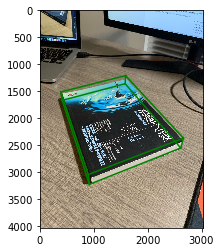

In [1731]:
## Draw bounding box for image 1

# visualize bounding box, P1 is the projection matrix you estimated for image 1
visualize_bounding_box_camera_coordinates(P1, points_3d, img1)

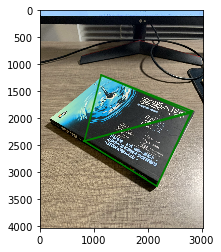

In [1732]:
## Draw bounding box for image 2

# visualize bounding box, P2 is the projection matrix you estimated for image 2
visualize_bounding_box_camera_coordinates(P2, points_3d, img2)

### Questions
*put these answers in your report*

1. As you may have noticed, the first three rows of the transformation matrix are just the extrinsic parameters of our camera, which means, 
$$[\ {}^w \mathbf{R}^T_c| -\ {}^w \mathbf{R}^T_c {}^w\mathbf{t}_c] = \mathbf{K^{-1}}\mathbf{K}[\ {}^c\mathbf{R}_w|\ {}^c\mathbf{t}_w]  = \mathbf{K^{-1}}\mathbf{K}[\ {}^w\mathbf{R}^T_c| - \ {}^w\mathbf{R}^T_c {}^w\mathbf{t}_c] = \mathbf{K^{-1}}\mathbf{P}$$
why is that?
2. Say if we know the coordinates of 3D points in camera 1 coordinate system, and we want to transform them into camera 2 coordinate system, what should we do? You may assume that the poses of both cameras are known.

# Part 4: Direct Linear Transform (DLT)

We have covered a non-linear least squares based optimization for pose estimation. In this section, we will formulate the problem as a linear system of equations.

Let's revisit the original equation for camera projection. As $P$ is a $3\times4$ matrix, we index its rows as $P^{i\top}$. A 3D points $\mathbf{X}$ (in homogenous coordinate system) is projected to 2D as:

$$
    \begin{bmatrix} P^{1\top} \\ P^{2\top} \\ P^{3\top} \end{bmatrix} \mathbf{X}
$$

If we have its corresponding 2d measurement $\mathbf{x}$, we can write that:
$$
    \mathbf{x} = \alpha \begin{bmatrix} P^{1\top} \\ P^{2\top} \\ P^{3\top} \end{bmatrix} \mathbf{X}
$$
where $\alpha$ is a positive constant. This is because we lose the scale information when we project a 3D point.

As $\mathbf{x}$ and $P \mathbf{X}$ are vectors in the same direction, their cross product will be zero:
$$
    \mathbf{x} \times \begin{bmatrix} P^{1\top} \\ P^{2\top} \\ P^{3\top} \end{bmatrix} \mathbf{X} = 0
$$

If $\mathbf{x} = \begin{bmatrix} x & y & w \end{bmatrix}^\top$, this equation can be simplified as:


$$
    \mathbf{x} \times \begin{bmatrix} P^{1\top} \\ P^{2\top} \\ P^{3\top} \end{bmatrix} \mathbf{X} \\
    = \begin{bmatrix} x \\ y \\ w \end{bmatrix} \begin{bmatrix} P^{1\top} \\ P^{2\top} \\ P^{3\top} \end{bmatrix} \mathbf{X} \\
    = \begin{bmatrix} x \\ y \\ w \end{bmatrix} \times \begin{bmatrix} P^{1\top} \mathbf{X} \\ P^{2\top} \mathbf{X} \\ P^{3\top} \mathbf{X} \end{bmatrix} \\
    = \begin{bmatrix} x \\ y \\ w \end{bmatrix} \times \begin{bmatrix} \mathbf{X}^\top P^{1} \\ \mathbf{X}^\top P^{2} \\ \mathbf{X}^\top P^{3}  \end{bmatrix} \\
    = \begin{bmatrix} y \mathbf{X}^\top P^{3} - w \mathbf{X}^\top P^{2} \\ w \mathbf{X}^\top P^{1} - x \mathbf{X}^\top P^{3} \\ x \mathbf{X}^\top P^{2} - y \mathbf{X}^\top P^{1} \end{bmatrix} \\
    =  \begin{bmatrix} 
    \mathbf{0}^\top & -w \mathbf{X}^\top & y \mathbf{X}^\top \\
    w \mathbf{X}^\top & \mathbf{0}^\top &  -x \mathbf{X}^\top \\
    - y \mathbf{X}^\top & x \mathbf{X}^\top & 0 
\end{bmatrix} \begin{bmatrix} P^1 \\ P^2 \\ P^3 \end{bmatrix}
$$
where $\mathbf{0}^\top$ is a 4-dimensional vector of all zeros.

As this cross product has to be zero, we obtain a homogeneous linear system of equation:
$$
\begin{bmatrix} 
    \mathbf{0}^\top & -w \mathbf{X}^\top & y \mathbf{X}^\top \\
    w \mathbf{X}^\top & \mathbf{0}^\top &  -x \mathbf{X}^\top \\
    - y \mathbf{X}^\top & x \mathbf{X}^\top & 0 
\end{bmatrix} \begin{bmatrix} P^1 \\ P^2 \\ P^3 \end{bmatrix} = 0
$$

We obtain 3 equations from one pair of 2D-3D correspondence. But note that the third row is actually a linear combination of other two rows. So we only obtain 2 equations from an input pair.

$$
\begin{bmatrix} 
    \mathbf{0}^\top & -w \mathbf{X}^\top & y \mathbf{X}^\top \\
    w \mathbf{X}^\top & \mathbf{0}^\top &  -x \mathbf{X}^\top \\
\end{bmatrix} \begin{bmatrix} P^1 \\ P^2 \\ P^3 \end{bmatrix} = 0
$$

P has 11 DoF, hence we need at least 11 equations to solve for P. This translates to the requirement of 6 points.


**Note:** Please work out this derivation by hand. It is important you understand this equation before proceeding further.

Hence for every pair $\{ \mathbf{x}_i, \mathbf{X}_i \}$, we get 2 equations in $P^{i}$. If we have $n$ points, we can construct a $2n\times12$ sized matrix A, and a homogeneous system of linear equations $A p = 0$, where $p$ is the flattened form of projection matrix $P$.

There are multiple approaches you can use to solve this equation. However, in reality $A p$ will never be equal to 0. This is because of measurement noise, precision error, etc.

Now, how do we solve this equation? A trivial solution is $p=0$, but that is not useful for us. Hence we will constraint $|p| = 1$.

If you recall some basic linear algebra, the solution to homogeous system $A p = 0$ is the null-space of matrix $A$, which is spanned by the eigenvectors of $A$ which have eigenvalue 0.

Now, we wont be able to solve the system exactly because of measurement error/precision error.

Hence, we can try to minimize $|| A p ||_2 $ subject to $||p||_2 = 1$. The solution to this optimization problem is the eigenvector of $A$ which has the minimum eigenvalue.

Hence, we know have a simple closed-form solution for $p$: We can use the singular value decomposition and pick the eigenvector which the lowest eigenvalue.

Ref: 
- http://www.cs.cmu.edu/~16385/s17/Slides/10.2_2D_Alignment__DLT.pdf
- http://newton.uam.mx/xgeorge/uea/graficacionII/homogeneous_equations.pdf

Summary:
- We covered an important cross-product trick to equality upto scale.
- We transformed our pose estimation problem into a homogeneous system and can use SVD to solve it.

**TODO:**
- Complete function `generate_homogenous_system()` in `dlt.py`
- Complete function `get_eigenvector_with_smallest_eigenvector()` in `dlt.py`

In [1733]:
from unit_tests.test_dlt import test_generate_homogenous_system, test_get_eigenvector_with_smallest_eigenvector

In [1734]:
print('Test for generate_homogenous_system:', verify(test_generate_homogenous_system))

Test for generate_homogenous_system: "Correct"


In [1735]:
print('Test for get_eigenvector_with_smallest_eigenvector:', verify(test_get_eigenvector_with_smallest_eigenvector))

Test for get_eigenvector_with_smallest_eigenvector: "Correct"


You have now completed the two functions required for this part. The final function `estimate_projection_matrix_dlt` is already complete and you should take a look at the code.

### Loading the data

We will reload the same data we used in part 1.

In [1736]:
# set the paths and load the data
pts2d_path = '../data/pts2d-pic_b.txt'
pts3d_path = '../data/pts3d.txt'
img_path   = '../data/pic_b.jpg'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(img_path)

In [1737]:
print('Shape of 2D points', points_2d.shape)
print('Shape of 3D points', points_3d.shape)

Shape of 2D points (20, 2)
Shape of 3D points (20, 3)


In [1738]:
from dlt import estimate_projection_matrix_dlt

In [1739]:
P = estimate_projection_matrix_dlt(points_2d, points_3d)

The projection matrix is
 [[-2.04586455e+00  1.18558243e+00  3.91381081e-01  2.44002874e+02]
 [-4.56804042e-01 -3.02392053e-01  2.14706068e+00  1.66030240e+02]
 [-2.24595257e-03 -1.09488059e-03  5.61389950e-04  1.00000000e+00]]
The total residual is 15.544953


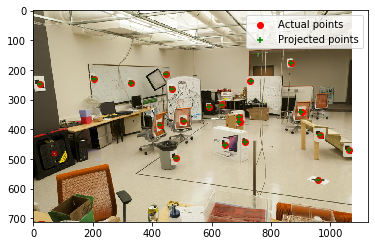

In [1740]:
print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/pic_b.jpg')

**Conclusion:** DLT is a simple algorithm to obtain a projection matrix. However, it is typically less accurate because we solve for the eigenvector with the lowest eigenvalue, and the lowest eigenvalue may not be close to zero. Hence it is usually used as an initialization step for the least-squares method.

### Questions
*put these answers in your report*

1. Why do we need the cross product trick?

2. We pick up the eigenvector with the smallest eigenvalue. Will this eigenvalue be exactly zero? Why/why not?

# Extra Credit: Robust Pose Estimation using RANSAC

In the previous 2 sections, we have have been supplied with 20 2D-3D correspondences, and they are all fairly noise-free.

However, we will always encounter noise in real world situations. In this section, we will load a new image with 82 marked outlier-free correspondences, and then we will add randomly generated data to obtain a corrupted input. The image is rendered from a 3D scene in Blender. The 3D scene is made by Alex Treviño, and you can find it on Blender cloud [here](https://cloud.blender.org/p/gallery/5dd6d7044441651fa3decb56).

We will see how DLT does a terrible job, and how RANSAC can do much better.

In [1660]:
# set the paths and load the data
pts2d_path = '../data/simulated_scene/uncorrupted_2d_a.txt'
pts3d_path = '../data/simulated_scene/uncorrupted_3d.txt'
img_path   = '../data/simulated_scene/sim_a.png'

points_2d_orig = np.loadtxt(pts2d_path)
points_3d_orig = np.loadtxt(pts3d_path)
img = load_image(img_path)

In [1661]:
print('Number of points = ', points_2d_orig.shape[0])

Number of points =  82


Let's add a small random noise as real world data frequently has some noise.

In [1662]:
points_2d = points_2d_orig + np.random.randn(points_2d_orig.shape[0], points_2d_orig.shape[1])*0.5
points_3d = points_3d_orig + np.random.randn(points_3d_orig.shape[0], points_3d_orig.shape[1])*1

In [1663]:
# Use DLT to estimate the projection matrix
P = estimate_projection_matrix_dlt(points_2d, points_3d)

The projection matrix is
 [[ 6.91625167e-01  1.98672731e+00  2.36624751e-01  1.28074776e+03]
 [-5.74872384e-01  7.09048278e-01 -1.62775811e+00  9.37352793e+02]
 [-6.96109961e-04  8.63162890e-04  2.31869693e-04  1.00000000e+00]]
The total residual is 175.697402


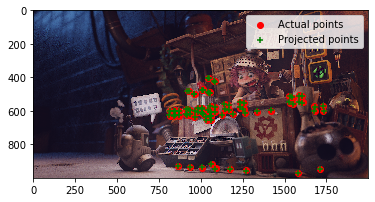

In [1664]:
print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/simulated_scene/sim_a.png')

Let us **corrupt the data**, i.e. data with incorrect 2D-3D correspondences. We will add randomly generated 2d-3d correspondences and sub-sample from the true correspondes we have from the disk.

In [1665]:
# get random correspondences
random_points_2d, random_points_3d = \
    generate_random_correspondences(40, img.shape[:2], (-300, -150, 0), (300, 100, 400))

In [1666]:
# merge the random correspondences with actual data
corrupted_points_2d = np.vstack((points_2d, random_points_2d))
corrupted_points_3d = np.vstack((points_3d, random_points_3d))

Now, lets try DLT on the corrupted data

In [1667]:
# Use DLT to estimate the projection matrix
P = estimate_projection_matrix_dlt(corrupted_points_2d, corrupted_points_3d)

The projection matrix is
 [[ 1.29850064e+00  3.16017522e+00 -4.67022175e+00  1.27457838e+03]
 [ 5.16431963e-01  1.80658319e+00 -3.06002972e+00  7.82731554e+02]
 [ 8.22557889e-04  2.25282205e-03 -3.87536013e-03  1.00000000e+00]]
The total residual is 141674.689221


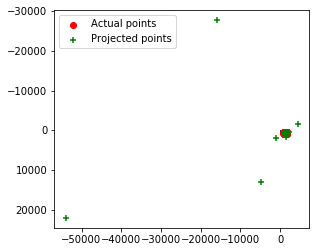

In [1668]:
print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/simulated_scene/sim_a.png')

It is evident that we cannot use a non-robust method for pose-estimation. Now, we will try using Ransac framework to estimate the pose. Note that we will be using the DLT algorithm for model fitting inside the ransac, you need to sample 6 correspondences in each iteration of ransac 

You can also find a simple explanation of RANSAC at 
https://www.mathworks.com/discovery/ransac.html.
See section 6.1.4 in the textbook for a more thorough explanation of how RANSAC works.

### RANSAC Iterations
Begin by calculating the number of iterations $S$ RANSAC will need to perform to guarentee a given success rate $P$ knowing the number of points included in the sample $k$ and the probability of an individual point being a true match $p$. To derive this formula, consider the following:
 * the probability that any one point has a true match is $p$
  * conversely the probability that any one point is not a match is $1-p$
  * the probability that two points are both matches is then $p \cdot p$
  * this can be extendeed to $k$ points, for which the probability that they are all true matches is $p^k$
 * on the other hand, we want the probability that $k$ points are all true matches to be $P$ (and the probability that they are not to be $1-P$)
 * by repeatedly sampling $k$ points, we can reduce the probability that all of the samples do not contain $k$ true matches
 * After $S$ samples we want the probability of failure to equal $1-P$
 
Start by setting up this equality $$1-P = ...$$
and then rearange it to write a function to solve for $S$

**TODO:**
- Complete function `calculate_num_ransac_iterations()` in `ransac.py`

In [1669]:
from ransac import calculate_num_ransac_iterations
from unit_tests.test_ransac import test_calculate_num_ransac_iterations

P = 0.999
k = 9
p = 0.90
S = calculate_num_ransac_iterations(P, k, p)
print('S =', int(S))

print("Test for calculate_num_ransac_iterations(): " + verify(test_calculate_num_ransac_iterations))

S = 15
Test for calculate_num_ransac_iterations(): "Correct"


### Questions
*put these answers in your report*

1.How many RANSAC iterations would we need to find the projection matrix with 99.9% certainty assuming that the input correspondences had a 90% accuracy?

2.One might imagine that if we had more than 6 point correspondences, it would be better to use more of them to solve for the projection matrix. Investigate this by finding the number of RANSAC iterations you would need to run with 12 points sampled for DLT in each iteration.

3.If our dataset had a lower point correspondence accuracy, say 70%, what is the minimum number of iterations needed to find the fundamental matrix with 99.9% certainty?

At the end of this part you will be performing RANSAC to find the projection matrix, and you will want to keep the estimated accuracy of your correspondences in mind when deciding how many iterations are appropriate.

### RANSAC Implementation
Next we will implement the RANSAC algorithm. Remember the steps from the link above:
 1. Randomly selecting a subset of the data set (coded for you)
 2. Fitting a model to the selected subset
    2.1 Use DLT to get initial estimate (**TODO** using `estimate_projection_matrix_dlt`)
    2.2 Use least squares to get the P for the sampled data (**TODO** using `estimate_camera_matrix`)
 3. Determining the number of outliers (**TODO** using `find_inliers`)
 4. Update the best model if needed.
 4. Repeating steps 1-3 for a prescribed number of iterations

Complete the TODOs inside the function `ransac_projection_matrix` in `ransac.py`. There is no unit test for this part.

In [1670]:
from ransac import ransac_projection_matrix

### Finally we will put it all together.


In [1879]:
num_iterations = calculate_num_ransac_iterations(0.999, 9, 0.7)

In [1880]:
print('Required number of iterations: ', num_iterations)

Required number of iterations:  168


In [1743]:
P, _, _ = ransac_projection_matrix(corrupted_points_2d, corrupted_points_3d, 8.0, num_iterations)

Time since optimization start 0.015901803970336914
Time since optimization start 0.007272243499755859
Time since optimization start 0.007905721664428711
Time since optimization start 0.007036924362182617
Time since optimization start 0.009648799896240234
Time since optimization start 0.019311189651489258
Time since optimization start 0.012738227844238281
Time since optimization start 0.012392044067382812
Time since optimization start 0.016800880432128906
Time since optimization start 0.008528947830200195
Time since optimization start 0.029618263244628906
Time since optimization start 0.02436685562133789
Time since optimization start 0.058966875076293945
Time since optimization start 0.07888603210449219
Time since optimization start 0.04746270179748535
Time since optimization start 0.11223912239074707
Time since optimization start 0.043550968170166016
Time since optimization start 0.04899406433105469
Time since optimization start 0.07897305488586426
Time since optimization start 0.05332

**TODO**: Please put the number of inliers from your best RANSAC model in your report.

The projection matrix is
 [[ 6.76514918e-01  2.04469948e+00 -8.63529118e-03  1.27232943e+03]
 [-5.31230475e-01  8.62301708e-01 -1.73700523e+00  9.43435334e+02]
 [-6.37086858e-04  9.73965068e-04  1.27069061e-05  1.00000000e+00]]
The total residual is 680.084275


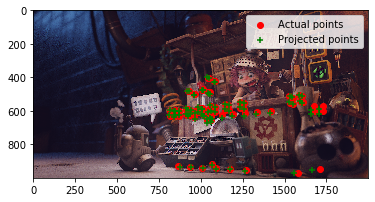

In [1681]:
print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/simulated_scene/sim_a.png')

**TODO**: Please put image and the total residual in your report.

## Rubric
- +57 pts: Code
    - 30 pts: Part 1
    - 15 pts: Part 3
    - 12 pts: Part 4
- +43 pts: Report
    - 3 pts: Part 1
    - 22 pts: Part 2
    - 8 pts: Part 3
    - 6 pts: Part 4
    - 4 pts: Conclusions and tests screenshot
- +8 pts: Extra Credit:
    - 4 pts: Code
    - 4 pts: Report

- -5*n pts: Lose 5 points for every time you do not follow the instructions for the hand-in format.

## Submission

This is very important as you will lose 5 points for every time you do not follow the instructions.

Do install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Do use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using python zip_submission.py --gt_username

## Credit

Assignment developed by Ayush Baid, Haoxin Ma, Jing Wu and Frank Dellaert, based on the original assignment by Jacob Knaup, Julia Chen, Stefan Stojanov, Frank Dellaert, and James Hays, which is based on a similar project by Aaron Bobick.